In [1]:
!pip install tensorflow scikit-learn pandas matplotlib imbalanced-learn


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [3]:
DATA_PATH = "letter-recognition.data"
HEADERS = [
    "lettr",
    "x-box",
    "y-box",
    "width",
    "high",
    "onpix",
    "x-bar",
    "y-bar",
    "x2bar",
    "y2bar",
    "xybar",
    "x2ybr",
    "xy2br",
    "x-ege",
    "xegvy",
    "y-ege",
    "yegvx",
]

In [4]:
data = pd.read_csv(DATA_PATH, header=None, names=HEADERS)

In [5]:
data.head()

,lettr,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [6]:
data["lettr"] = data["lettr"].apply(lambda x: ord(x) - 65)

# Preprocessing

In [7]:
data.shape

(20000, 17)

<BarContainer object of 26 artists>

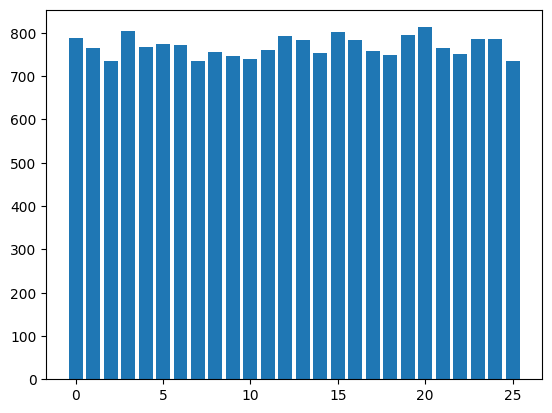

In [8]:
plt.bar(data["lettr"].value_counts().index, data["lettr"].value_counts().values)

In [9]:
# remove duplicates
data.drop_duplicates(inplace=True)

In [10]:
data.shape

(18668, 17)

<BarContainer object of 26 artists>

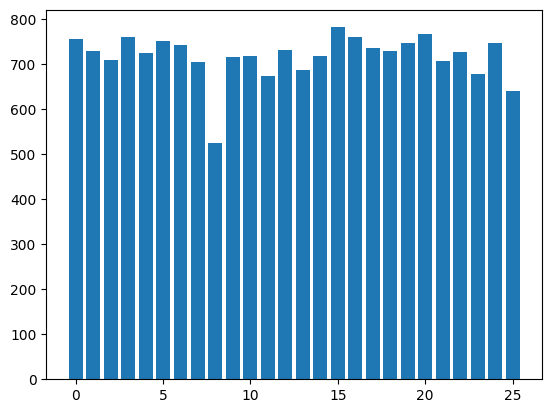

In [11]:
plt.bar(data["lettr"].value_counts().index, data["lettr"].value_counts().values)

In [12]:
# Under sampling
rus = RandomUnderSampler(random_state=42)
under_sample, under_sample_labels = rus.fit_resample(data[HEADERS[1:]], data[HEADERS[0]])

In [13]:
under_sample.shape

(13624, 16)

<BarContainer object of 26 artists>

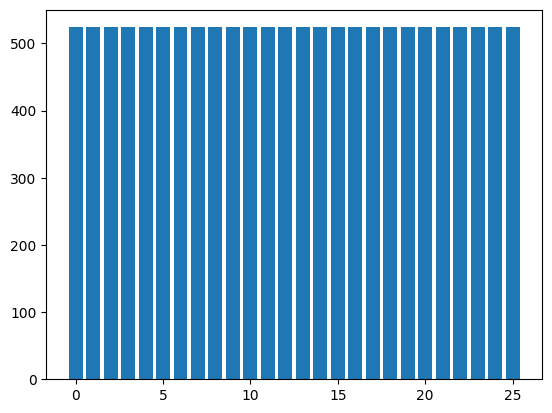

In [14]:
plt.bar(
    pd.Series(under_sample_labels).value_counts().index,
    pd.Series(under_sample_labels).value_counts().values,
)

In [15]:
# Over sampling
ros = RandomOverSampler(random_state=42)
over_sample, over_sample_labels = ros.fit_resample(data[HEADERS[1:]], data[HEADERS[0]])

In [16]:
over_sample.shape

(20332, 16)

<BarContainer object of 26 artists>

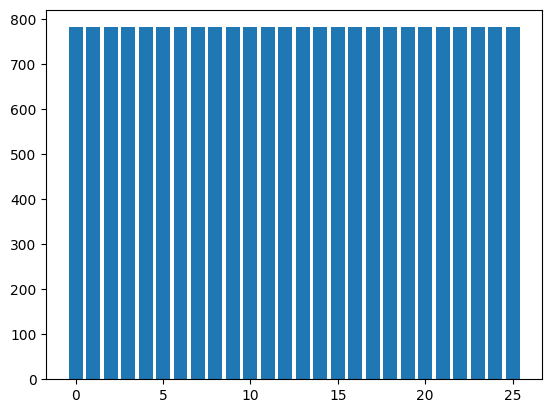

In [17]:
plt.bar(
    pd.Series(over_sample_labels).value_counts().index,
    pd.Series(over_sample_labels).value_counts().values,
)

In [18]:
# SMOTE
smote = SMOTE(random_state=42)
smote_sample, smote_sample_labels = smote.fit_resample(data[HEADERS[1:]], data[HEADERS[0]])

In [19]:
smote_sample.shape

(20332, 16)

<BarContainer object of 26 artists>

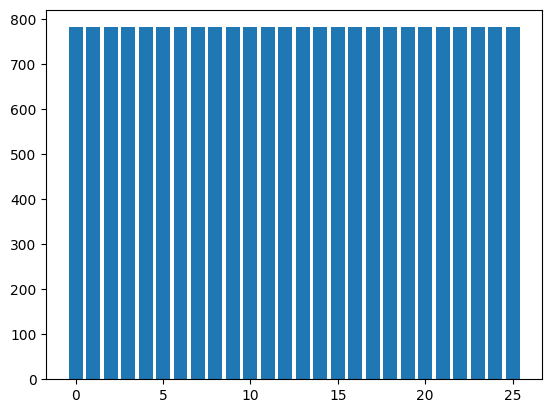

In [20]:
plt.bar(
    pd.Series(smote_sample_labels).value_counts().index,
    pd.Series(smote_sample_labels).value_counts().values,
)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(
    data[HEADERS[1:]], data[HEADERS[0]], test_size=0.20, random_state=42
)
x_train_smote, x_test_smote, y_train_smote, y_test_smote = train_test_split(
    smote_sample, smote_sample_labels, test_size=0.20, random_state=42
)
x_train_under, x_test_under, y_train_under, y_test_under = train_test_split(
    under_sample, under_sample_labels, test_size=0.20, random_state=42
)
x_train_over, x_test_over, y_train_over, y_test_over = train_test_split(
    over_sample, over_sample_labels, test_size=0.20, random_state=42
)
x_train_over.shape, x_test_over.shape, y_train_over.shape, y_test_over.shape

((16265, 16), (4067, 16), (16265,), (4067,))

In [22]:
x_train = tf.keras.utils.normalize(x_train.values, axis=1)
x_test = tf.keras.utils.normalize(x_test.values, axis=1)

In [23]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(26, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model.fit(x_train, y_train, epochs=30)

Epoch 1/30
467/467 [==============================] - 0s 651us/step - loss: 2.1723 - accuracy: 0.4077
Epoch 2/30
467/467 [==============================] - 0s 644us/step - loss: 1.3132 - accuracy: 0.6306
Epoch 3/30
467/467 [==============================] - 0s 634us/step - loss: 1.1185 - accuracy: 0.6858
Epoch 4/30
467/467 [==============================] - 0s 637us/step - loss: 1.0029 - accuracy: 0.7168
Epoch 5/30
467/467 [==============================] - 0s 636us/step - loss: 0.9296 - accuracy: 0.7341
Epoch 6/30
467/467 [==============================] - 0s 625us/step - loss: 0.8692 - accuracy: 0.7518
Epoch 7/30
467/467 [==============================] - 0s 633us/step - loss: 0.8114 - accuracy: 0.7658
Epoch 8/30
467/467 [==============================] - 0s 645us/step - loss: 0.7662 - accuracy: 0.7763
Epoch 9/30
467/467 [==============================] - 0s 639us/step - loss: 0.7180 - accuracy: 0.7874
Epoch 10/30
467/467 [==============================] - 0s 622us/step - loss: 0.672

In [24]:
model.evaluate(x_test, y_test)

117/117 [==============================] - 0s 400us/step - loss: 0.2990 - accuracy: 0.9071


[0.29897770285606384, 0.9070701599121094]

In [25]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(26, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model.fit(over_sample, over_sample_labels, epochs=15)

Epoch 1/15
636/636 [==============================] - 1s 704us/step - loss: 1.2577 - accuracy: 0.6462
Epoch 2/15
636/636 [==============================] - 0s 715us/step - loss: 0.6380 - accuracy: 0.8094
Epoch 3/15
636/636 [==============================] - 0s 683us/step - loss: 0.4478 - accuracy: 0.8628
Epoch 4/15
636/636 [==============================] - 0s 676us/step - loss: 0.3484 - accuracy: 0.8921
Epoch 5/15
636/636 [==============================] - 0s 688us/step - loss: 0.2883 - accuracy: 0.9083
Epoch 6/15
636/636 [==============================] - 0s 678us/step - loss: 0.2497 - accuracy: 0.9207
Epoch 7/15
636/636 [==============================] - 0s 637us/step - loss: 0.2230 - accuracy: 0.9281
Epoch 8/15
636/636 [==============================] - 0s 663us/step - loss: 0.1973 - accuracy: 0.9358
Epoch 9/15
636/636 [==============================] - 0s 640us/step - loss: 0.1831 - accuracy: 0.9397
Epoch 10/15
636/636 [==============================] - 0s 625us/step - loss: 0.165

In [26]:
model.evaluate(x_test_over, y_test_over)

128/128 [==============================] - 0s 413us/step - loss: 0.0835 - accuracy: 0.9749


[0.0834890827536583, 0.9749200940132141]

In [27]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(26, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model.fit(under_sample, under_sample_labels, epochs=25)

Epoch 1/25
426/426 [==============================] - 0s 629us/step - loss: 1.4730 - accuracy: 0.5774
Epoch 2/25
426/426 [==============================] - 0s 649us/step - loss: 0.8368 - accuracy: 0.7522
Epoch 3/25
426/426 [==============================] - 0s 719us/step - loss: 0.6361 - accuracy: 0.8089
Epoch 4/25
426/426 [==============================] - 0s 682us/step - loss: 0.5107 - accuracy: 0.8437
Epoch 5/25
426/426 [==============================] - 0s 658us/step - loss: 0.4200 - accuracy: 0.8731
Epoch 6/25
426/426 [==============================] - 0s 670us/step - loss: 0.3599 - accuracy: 0.8900
Epoch 7/25
426/426 [==============================] - 0s 687us/step - loss: 0.3053 - accuracy: 0.9066
Epoch 8/25
426/426 [==============================] - 0s 664us/step - loss: 0.2641 - accuracy: 0.9159
Epoch 9/25
426/426 [==============================] - 0s 682us/step - loss: 0.2391 - accuracy: 0.9232
Epoch 10/25
426/426 [==============================] - 0s 655us/step - loss: 0.211

In [28]:
model.evaluate(x_test_under, y_test_under)

86/86 [==============================] - 0s 403us/step - loss: 0.0986 - accuracy: 0.9655


[0.09861212968826294, 0.9655045866966248]

In [29]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [30]:
y_pred = knn.predict(x_test)

In [31]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       144
           1       0.89      0.96      0.93       156
           2       0.94      0.93      0.93       147
           3       0.89      0.96      0.93       163
           4       0.87      0.92      0.89       144
           5       0.92      0.93      0.93       146
           6       0.95      0.88      0.91       173
           7       0.87      0.87      0.87       133
           8       0.96      0.94      0.95       108
           9       0.95      0.95      0.95       150
          10       0.90      0.91      0.90       149
          11       0.99      0.97      0.98       147
          12       0.99      0.99      0.99       143
          13       0.96      0.96      0.96       138
          14       0.93      0.95      0.94       131
          15       0.96      0.94      0.95       161
          16       0.97      0.97      0.97       145
          17       0.93    

In [32]:
param_grid = {"n_neighbors": [3, 5, 7, 9, 11, 13, 15]}
grid = GridSearchCV(knn, param_grid, n_jobs=-1)
grid.fit(x_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15]})

In [33]:
print(grid.best_params_)

{'n_neighbors': 3}
